In [4]:
!pip install livelossplot

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from livelossplot import PlotLossesKerasTF
from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split

In [6]:
#Loading dataset
train1 = pd.read_parquet('dataset/train-00000-of-00002.parquet', engine='pyarrow')
train2 = pd.read_parquet('dataset/train-00001-of-00002.parquet', engine='pyarrow')
test = pd.read_parquet('dataset/test-00000-of-00001.parquet', engine='pyarrow')
validation = pd.read_parquet('dataset/validation-00000-of-00001.parquet', engine='pyarrow')

In [7]:
# Concatenate train1 and train 2
train = pd.concat([train1, train2], axis=0, ignore_index=True)

In [8]:
def prepare_text_data(text, max_sequence_len, max_vocab_size=10000):
    # Initialize the tokenizer with a limited vocabulary size
    tokenizer = Tokenizer(num_words=max_vocab_size)
    tokenizer.fit_on_texts([text])
    total_words = min(max_vocab_size, len(tokenizer.word_index) + 1)

    input_sequences = []
    for line in text.split('\n'):
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
    label = to_categorical(label, num_classes=total_words)

    return predictors, label, tokenizer, total_words

In [9]:
prepare_text_data(train.iloc[1].text,15)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]]),
 array([[0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 4)

In [10]:
def build_model(max_sequence_len, total_words):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(total_words, 64, input_length=max_sequence_len-1),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(total_words, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

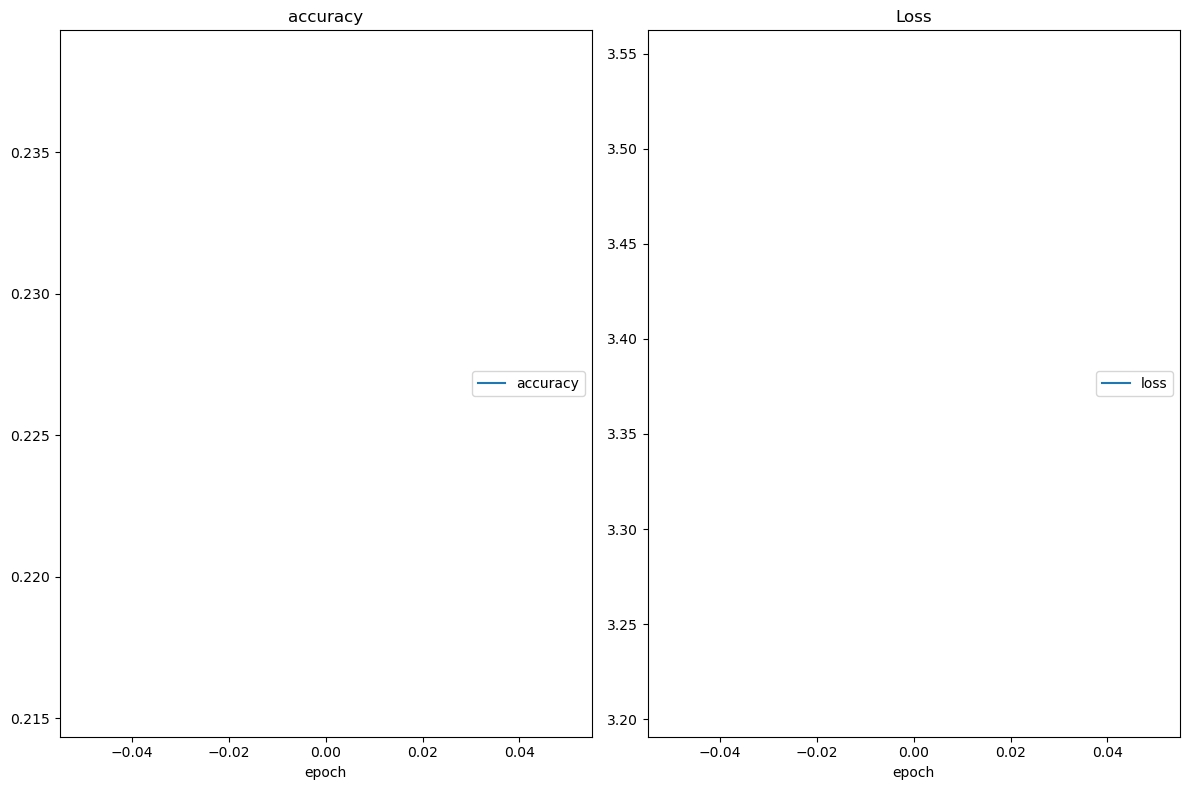

accuracy
	accuracy         	 (min:    0.227, max:    0.227, cur:    0.227)
Loss
	loss             	 (min:    3.377, max:    3.377, cur:    3.377)
27838/27838 ━━━━━━━━━━━━━━━━━━━━ 541s 19ms/step - accuracy: 0.2202 - loss: 3.4399


In [14]:
# Combine text data for tokenization
if train is not None:
    train_data, _ = train_test_split(train, test_size=0.8, random_state=5)
    combined_text = ' '.join(train_data['text'].tolist())

    # Tokenize and prepare sequences
    max_sequence_len = 5
    max_vocab_size = 100  # Limit vocabulary size
    predictors, label, tokenizer, total_words = prepare_text_data(combined_text, max_sequence_len,max_vocab_size)

    # Build and compile the model
    model = build_model(max_sequence_len, total_words)

    # Train the model
    #model.fit(predictors, label, epochs=100, verbose=1)
    model.fit(predictors, label, epochs=1, batch_size=256, verbose=1, callbacks=[PlotLossesKeras()])

    # Save the model
    model.save('/content/drive/My Drive/Text-Generation-with-RNNs/models/text_generation_model.h5')

In [16]:
# Function to generate text
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=-1)
        output_word = tokenizer.index_word[predicted_word_index[0]]
        seed_text += " " + output_word
    return seed_text

In [ ]:
# Generate and print sample text
print(generate_text("Once upon a time playing", 5, model, max_sequence_len))